# Fake and Real News Detection

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Import all required and helper libraries here
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

%matplotlib inline

print ("Numpy Version - ", np.__version__)
print ("Pandas Version - ", pd.__version__)

Numpy Version -  1.18.5
Pandas Version -  1.0.5


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/weishin/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Reading raw data from csv and further process the news column
STOP_WORDS = stopwords.words("english")

#dataset_path = "/Users/weishin/Desktop/MyHobby/NewsAnalysis/dataset/"
dataset_path = r"dataset/"

In [3]:
# Functions used for words processing

def filterword (x):
    desc = x.split()
    tokenized = []
    
    for stemmed_word in desc:
        tokenized.append(word_tokenize(stemmed_word))
    
    filtered = []
    
    #removing STOPWORDS
    for count in range (0, len(tokenized)):
        for word in tokenized[count]:
            if word.lower() not in STOP_WORDS:
                filtered.append(word.lower())  
    
    filtered_string = " ".join(filtered)
    return filtered_string

#Removing regular expression, https, rt and changing to lowercase
def cleaning (x):
    stage1 = re.sub(r'[^0-9a-zA-Z\ ]', '', x).lower()
    stage2 = stage1.strip()
    return stage2

def listToString (data):
    str = " "
    return(str.join(data))

def datasplit(df):
    full_array_size = len(df)
    split_array_size = int(full_array_size*0.80)

    train_data = df[0:split_array_size]
    test_data = df[split_array_size:full_array_size]
    
    return (train_data, test_data)

def numericLabel (stringLabel):
    if stringLabel == 'FAKE':
        return 1
    if stringLabel == 'REAL':
        return 0

In [4]:
# First level processing of true and fake news
fake_df = pd.read_csv(dataset_path + "Fake.csv")
true_df = pd.read_csv(dataset_path + "True.csv")

fake_df['label'] = 'FAKE'
true_df['label'] = 'REAL'

fake_df['title processed'] = fake_df['title'].apply(cleaning)
fake_df['title processed'] = fake_df['title processed'].apply(filterword)
fake_processed_df = fake_df[['title processed', 'subject', 'label']]
fake_processed_df.to_csv(dataset_path + "Fake_processed.csv", index=False)

true_df['title processed'] = true_df['title'].apply(cleaning)
true_df['title processed'] = true_df['title processed'].apply(filterword)
true_processed_df = true_df[['title processed', 'subject', 'label']]
true_processed_df.to_csv(dataset_path + "True_processed.csv", index=False)

In [5]:
# Second level processing of true and fake news
fake_news_df = pd.read_csv(dataset_path + "Fake_processed.csv")
true_news_df = pd.read_csv(dataset_path + "True_processed.csv")
   
all_news_df = pd.concat([fake_news_df, true_news_df])

all_news_df = all_news_df.dropna()
all_news_df = all_news_df[all_news_df['subject'].str.match("(News|politics|Government News|left-news|US_News|Middle-east|politicsNews|worldnews)")]

print (all_news_df.shape)
all_news_df['subject'].unique()

(44877, 3)


array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east', 'politicsNews', 'worldnews'], dtype=object)

In [6]:
# Preparing for Sentiment Analysis
sid = SentimentIntensityAnalyzer()

# Array to hold sentiment score
compound = []
positive = []
neutral = []
negative = []

for sentence in all_news_df['title processed']:
    ss = sid.polarity_scores(sentence)
    compound.append(ss['compound'])
    positive.append(ss['pos'])
    neutral.append(ss['neu'])
    negative.append(ss['neg'])

all_news_df['compound'] = compound
all_news_df['positive'] = positive
all_news_df['neutral'] = neutral
all_news_df['negative'] = negative

all_news_df.to_csv("All_news_sentiments.csv", index=False)
all_news_df.head()

,title processed,subject,label,compound,positive,neutral,negative
0,donald trump sends embarrassing new years eve ...,News,FAKE,-0.7096,0.000,0.543,0.457
1,drunk bragging trump staffer started russian c...,News,FAKE,-0.3400,0.000,0.745,0.255
2,sheriff david clarke becomes internet joke thr...,News,FAKE,-0.2960,0.162,0.588,0.250
3,trump obsessed even obamas name coded website ...,News,FAKE,-0.1779,0.000,0.805,0.195
4,pope francis called donald trump christmas speech,News,FAKE,0.0000,0.000,1.000,0.000


In [7]:
# Preparing data for WordCloud 
label_keys = ['FAKE', 'REAL']
all_news_labels = []

for key in label_keys:
    cond1 = all_news_df['label'] == key
    temp_df = all_news_df[cond1][['title processed', 'compound', 'label']]
    all_news_labels.append(temp_df)
    
all_news_labels

[                                         title processed  compound label
 0      donald trump sends embarrassing new years eve ...   -0.7096  FAKE
 1      drunk bragging trump staffer started russian c...   -0.3400  FAKE
 2      sheriff david clarke becomes internet joke thr...   -0.2960  FAKE
 3      trump obsessed even obamas name coded website ...   -0.1779  FAKE
 4      pope francis called donald trump christmas speech    0.0000  FAKE
 ...                                                  ...       ...   ...
 23497  mcpain john mccain furious iran treated us sai...   -0.3818  FAKE
 23498  justice yahoo settles email privacy classactio...    0.5267  FAKE
 23499  sunnistan us allied safe zone plan take territ...    0.4404  FAKE
 23500  blow 700 million al jazeera america finally ca...    0.0000  FAKE
 23501  10 us navy sailors held iranian military signs...    0.0000  FAKE
 
 [23460 rows x 3 columns],
                                          title processed  compound label
 0      u

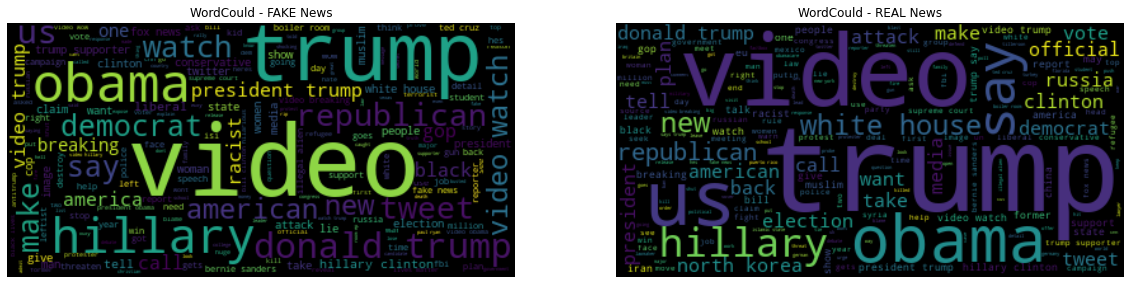

In [8]:
data = []
fig = plt.figure(figsize=(20,8))

for label_series in range(0,2):
    text_row = all_news_labels[label_series]['title processed']
    
    for row in text_row:
        data.append(row)
    
    text = listToString(data)    
    wordcloud = WordCloud().generate(text)
    
    ax1 = fig.add_subplot(1,2,label_series+1)
    ax1.imshow(wordcloud, interpolation='bilinear')
    ax1.axis("off")
    ax1.set_title("WordCould - " + label_keys[label_series] + " News")

plt.savefig("WordCloud_news.png")
plt.show()    

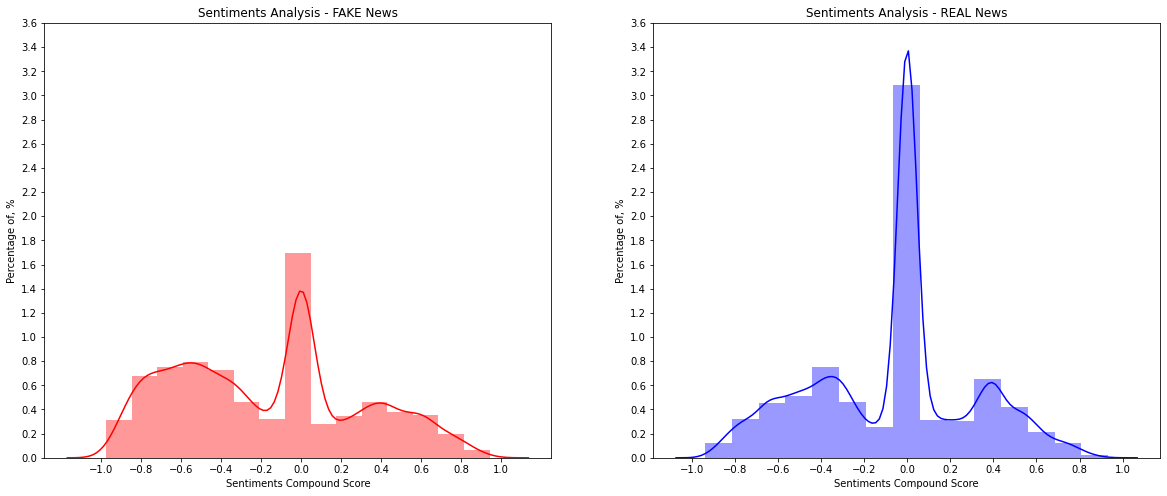

In [9]:
fig = plt.figure(figsize=(20,8))
color = ['red', 'blue']

for label_series in range(0,2):
    sentiment = all_news_labels[label_series]['compound']
    ax1 = fig.add_subplot(1,2,label_series+1)
    ax1 = sns.distplot(a=sentiment, bins=15, color=color[label_series])
    ax1.set_ylabel("Percentage of, %")
    ax1.set_yticks(np.arange(0, 3.8, 0.2))
    ax1.set_xlabel("Sentiments Compound Score")
    ax1.set_xticks(np.arange(-1.0, 1.2, 0.2))
    ax1.set_title("Sentiments Analysis - " + label_keys[label_series] + " News")
    
plt.savefig("Sentiments_news.png")
plt.show()

In [10]:
all_news_analysis_df = all_news_df[['title processed', 'subject', 'label']]
all_news_analysis_df['label numeric'] = all_news_analysis_df['label'].apply(numericLabel)

print(all_news_analysis_df['subject'].unique())
all_news_analysis_df.head()

['News' 'politics' 'Government News' 'left-news' 'US_News' 'Middle-east'
 'politicsNews' 'worldnews']


,title processed,subject,label,label numeric
0,donald trump sends embarrassing new years eve ...,News,FAKE,1
1,drunk bragging trump staffer started russian c...,News,FAKE,1
2,sheriff david clarke becomes internet joke thr...,News,FAKE,1
3,trump obsessed even obamas name coded website ...,News,FAKE,1
4,pope francis called donald trump christmas speech,News,FAKE,1


In [11]:
# Repartition the data for 80% (train data) and 20% (test data)

train_data_list = []
test_data_list = []

subjects = ['News', 'politics', 'Government News', 'left-news', 'US_News', 
           'Middle-east', 'politicsNews', 'worldnews']

for subject in subjects:
    cond2 = all_news_analysis_df['subject'] == subject
    temp1_df = all_news_analysis_df[cond2][['title processed', 'label numeric']]
    temp_train_data_df, temp_test_data_df = datasplit(temp1_df)
    
    train_data_list.append(temp_train_data_df)
    test_data_list.append(temp_test_data_df)
    
train_data_df = pd.DataFrame()
test_data_df = pd.DataFrame()
    
train_data_df = pd.concat([train_data_list[0], train_data_list[1], train_data_list[2], train_data_list[3],
                          train_data_list[4], train_data_list[5], train_data_list[6], train_data_list[7]])
test_data_df = pd.concat([test_data_list[0], test_data_list[1], test_data_list[2], test_data_list[3],
                         test_data_list[4], test_data_list[5], test_data_list[6], test_data_list[7]])

print ("Total train data size -", len(train_data_df))
print ("Total test data size -", len(test_data_df))

Total train data size - 35900
Total test data size - 8977


In [12]:
# Preparing data structures for machine learning

x_train = train_data_df[['title processed']]
x_test = test_data_df[['title processed']]
y_train = train_data_df['label numeric']
y_test = test_data_df['label numeric']

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

vectorizer = CountVectorizer()
desc_matrix = vectorizer.fit_transform(x_train['title processed'])

print(desc_matrix.shape)
print(desc_matrix.A)

(35900, 1) (8977, 1)
(35900,) (8977,)
(35900, 23454)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [13]:
# Use Multinomial Naive Bayes Classifier for prediction

desc_classifier = MultinomialNB()
desc_classifier.fit(desc_matrix, y_train)

MultinomialNB()

(8977, 23454)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
The confusion matrix for Fake/Real news predictions - 
 [[3707  577]
 [ 295 4398]]
0 - Real News, 1 - Fake News


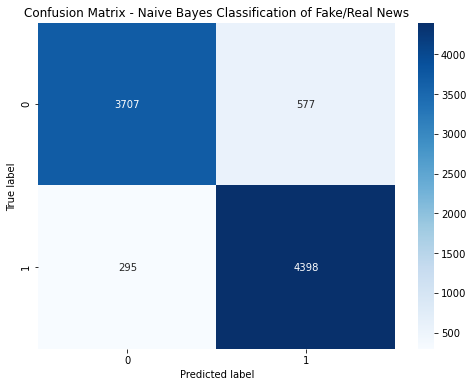

In [14]:
# Evaluate Accuracy and Precision of Naive Bayes Classifier prediction

# Use transform instead of fit for test datasets
x_matrix = vectorizer.transform(x_test['title processed'])
print (x_matrix.shape)
print (x_matrix.A)

predicted_results = desc_classifier.predict(x_matrix)
actual_results = y_test

news_mnb = confusion_matrix(actual_results, predicted_results)
print ("The confusion matrix for Fake/Real news predictions - \n", news_mnb)
print ("0 - Real News, 1 - Fake News")

fig = plt.figure(figsize=(8,6))
ax = sns.heatmap(news_mnb, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Naive Bayes Classification of Fake/Real News")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xlim(0,2)
plt.ylim(2,0)

plt.savefig("news_predict_nb_heatmap.png")
plt.show()

In [15]:
# Report the Accuracy of the model
print ("Accuracy -", accuracy_score(actual_results, predicted_results, sample_weight=None))
# print ("Accuracy -", desc_classifier.score(x_matrix ,y_test, sample_weight=None))
# Report the Precision of the model (Tp/Tp+Fp)
print ("Precision -", precision_score(actual_results, predicted_results, sample_weight=None))
# Report the Recall of the model (Tp/Tp+Fn)
print ("Recall -", recall_score(actual_results, predicted_results, sample_weight=None))

Accuracy - 0.9028628717834466
Precision - 0.8840201005025126
Recall - 0.9371404219049648


In [16]:
x_pdt = ['Trump from Republican', 'Trump from Democrat', 'Trump is racist', 'Clinton is racist']
x_matrix_pdt = vectorizer.transform(x_pdt)
print (x_matrix_pdt.shape)
print (x_matrix_pdt.A)

y_pdt_results = desc_classifier.predict(x_matrix_pdt)
print (x_pdt)
print ("0 - Real News, 1 - Fake News")
print ("The predicted news -", y_pdt_results)

(4, 23454)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
['Trump from Republican', 'Trump from Democrat', 'Trump is racist', 'Clinton is racist']
0 - Real News, 1 - Fake News
The predicted news - [0 1 1 1]
